# Sun Spot Activity Time Series

Monthly Mean Total Sunspot Number - form January 1749 to December 2019.

269 years, 3252 months of data.

In [1]:
import kaggle #api token file required
import os
import shutil
import zipfile
import pandas as pd
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Download, Unzip, Load

In [2]:
!kaggle datasets download -d robervalt/sunspots

# target folder
local_zip = f'{os.getcwd()}\\Data\\sunspots.zip'

# cut and paste
shutil.move(f'{os.getcwd()}\\sunspots.zip', local_zip)


  0%|          | 0.00/22.4k [00:00<?, ?B/s]
100%|##########| 22.4k/22.4k [00:00<00:00, 2.56MB/s]


'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Data\\sunspots.zip'

In [3]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}\\data')
zip_ref.close()

## Step 2: Read csv and Explore

Pandas dataframes allow for very neat, tabular representation of csv files.

In [4]:
df = pd.read_csv(f'{os.getcwd()}\\data\\sunspots.csv')
df

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3247,3247,2019-08-31,0.5
3248,3248,2019-09-30,1.1
3249,3249,2019-10-31,0.4
3250,3250,2019-11-30,0.5


However, for the remainder of the project we will use Numpy arrays.

In [5]:
time_step = []
sunspots = []

with open(f'{os.getcwd()}\\Data\\sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # the next() function skips the first line (header) when looping
  for row in reader:
    sunspots.append(float(row[2])) # sun spot value cast to float
    time_step.append(int(row[0]))  # the index of the csv gets read into time_step variable

In [6]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    myplot = plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunpots")
    if label != None:
        plt.legend()
    plt.grid(True)

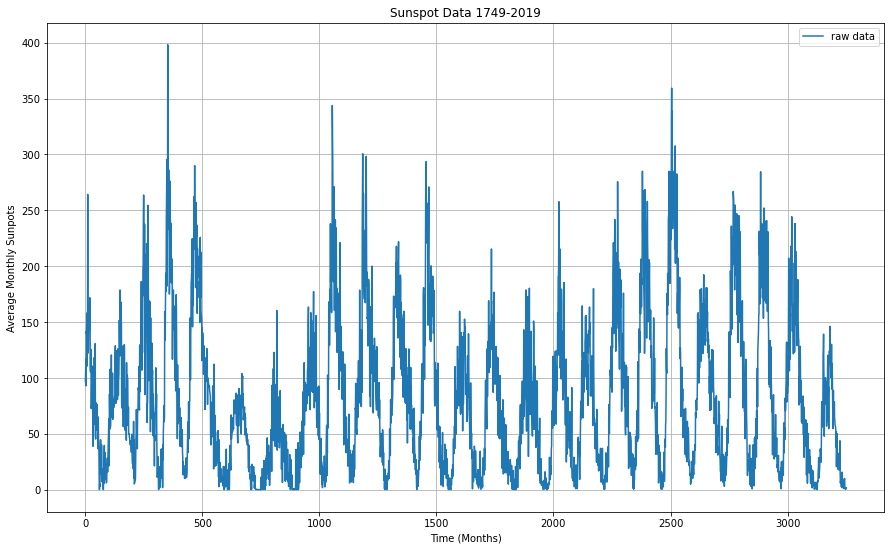

In [7]:
series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(15, 9))
plt.title("Sunspot Data 1749-2019")
plot_series(time, series, label="raw data")

## Step 3: Pre-Processing
### Split into Test and Validation Sets

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# the window size is important for training results
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

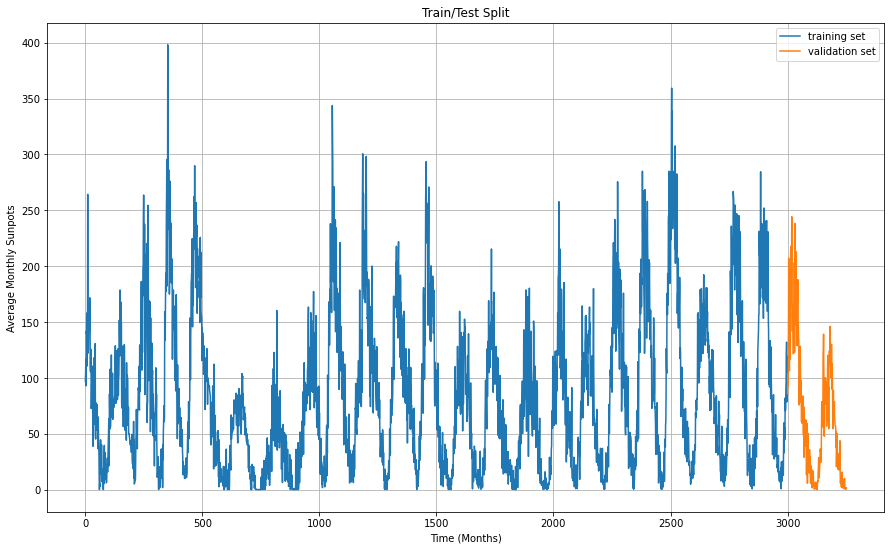

In [9]:
plt.figure(figsize=(15, 9))
plt.title("Train/Test Split")
plot_series(time_train, x_train, label="training set")
plot_series(time_valid, x_valid, label="validation set")

### Helper function for slicing data into time-series windows

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

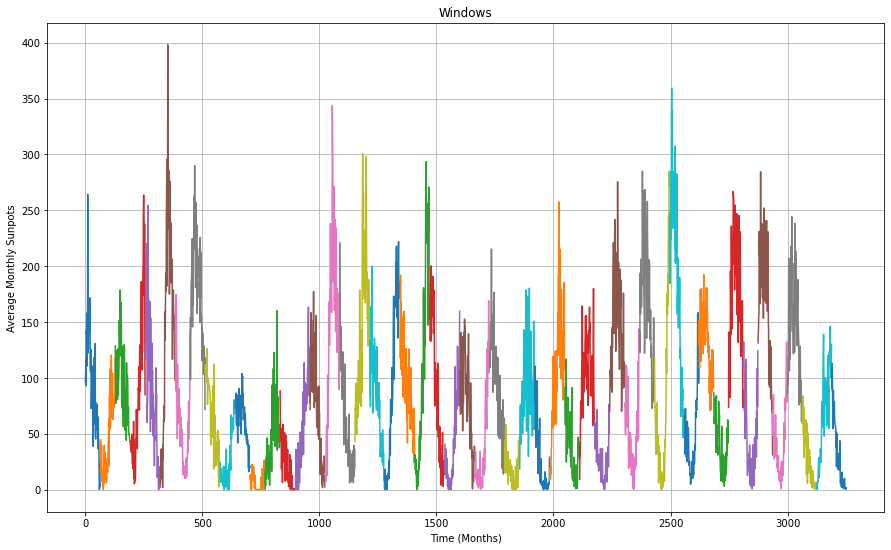

In [11]:
window_size = 64

def plot_split(array, window_size):
    number_windows = len(array) // window_size + 1
    return np.array_split(array, number_windows, axis=0)

plt.figure(figsize=(15, 9))
plt.title("Windows")

for series_window,time_window in zip(plot_split(series,window_size), plot_split(time,window_size)):
    plot_series(time_window, series_window)

## Step 4: Train for Learning Rate Optimization

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


Text(0, 0.5, 'Loss')

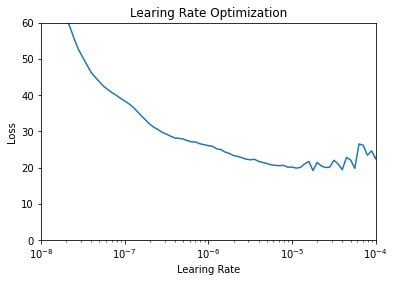

In [13]:
# pick lr from graph
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.title('Learing Rate Optimization')
plt.xlabel("Learing Rate")
plt.ylabel("Loss")

## Step 5: Train with Optimized Learning Rate

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500, verbose=0)

<Figure size 432x288 with 0 Axes>

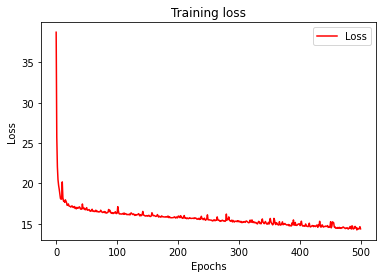

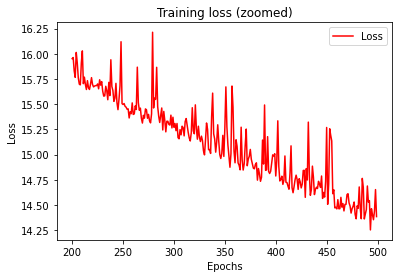

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(len(loss))

# full graph
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

# zoomed graph
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss (zoomed)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

## Step 6: Forecasting and Evaluating

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

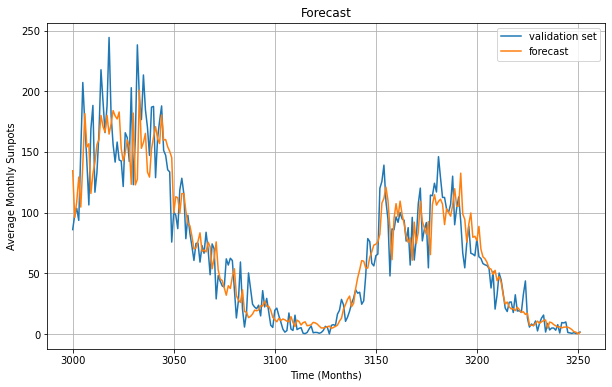

In [18]:
plt.figure(figsize=(10, 6))
plt.title("Forecast")
plot_series(time_valid, x_valid, label='validation set')
plot_series(time_valid, rnn_forecast, label='forecast')

In [19]:
print('Mean Absolute Error (MAE): ',tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

Mean Absolute Error (MAE):  14.530751


In [20]:
print(rnn_forecast)

[1.34511734e+02 9.59575729e+01 1.08832619e+02 1.29342361e+02
 1.04548882e+02 1.39415985e+02 1.81563599e+02 1.54046600e+02
 1.56698303e+02 1.15750885e+02 1.31930573e+02 1.41373199e+02
 1.56014771e+02 1.60105270e+02 1.80095703e+02 1.70937103e+02
 1.66246552e+02 1.80144684e+02 1.64668015e+02 1.73122269e+02
 1.84064957e+02 1.79739716e+02 1.77147919e+02 1.82903030e+02
 1.52896149e+02 1.42573425e+02 1.49297546e+02 1.59761780e+02
 1.54677795e+02 1.23341110e+02 1.82019882e+02 1.22861313e+02
 1.27474121e+02 2.00972366e+02 1.52975342e+02 1.57811493e+02
 1.65263336e+02 1.33440704e+02 1.29264923e+02 1.52362640e+02
 1.62125641e+02 1.70829803e+02 1.61084335e+02 1.56880325e+02
 1.80386871e+02 1.59741379e+02 1.60198593e+02 1.54253723e+02
 1.50491470e+02 1.45328018e+02 9.97249756e+01 1.13076149e+02
 1.12267662e+02 9.92869415e+01 1.15754471e+02 1.15574738e+02
 1.01128639e+02 9.12817535e+01 8.91956100e+01 8.04469757e+01
 6.99720612e+01 7.09744720e+01 7.62942734e+01 8.33442307e+01
 6.79476776e+01 6.922598